In [1]:
import pandas as pd
import numpy as np
import io, re
from unidecode import unidecode
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

In [2]:
archive = "Corpus.csv"

In [3]:
with open(archive, 'r') as myfile:
    data = myfile.read().encode('latin1').decode('utf8')
    df = pd.read_csv(io.StringIO(re.sub('"\s*\n','"',data)), delimiter=',')

In [4]:
df.head(10)

,#,Frases,Tipo,Resposta,Ação a ser Realizada,Ações Necessárias
0,1,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Acender a Lâmpada
1,2,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada,Apagar Lâmpada
2,3,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada,Ligar Ventilador
3,4,Já está claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Ventilador
4,5,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada,Ligar Televisão
5,6,"Casa, apague a luz",Explicito,Apagando a lâmpada.,Apagar Lâmpada,Desligar Televisão
6,7,O ar está muito parado,Implicito,Ligando o ventilador.,Ligar Ventilador,Aumentar Volume
7,8,Está muito quente aqui,Implicito,Ligando o ventilador.,Ligar Ventilador,Diminuir Volume
8,9,Que calor!,Implicito,Deseja ligar o ventilador?,Ligar Ventilador,Mudar Canal
9,10,"Está muito barulho, desligue o ventilador",Explicito,Desligando o ventilador.,Desligar Ventilador,NaN


In [5]:
df = df.drop(columns=['#', 'Ações Necessárias'])

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [7]:
df['Frases'] = df['Frases'].apply(unidecode)

In [8]:
def replace_i(v):
    return v.replace('í', 'i')

In [9]:
df['Tipo'] = df['Tipo'].apply(replace_i)

In [10]:
df.head(5)

,Frases,Tipo,Resposta,Ação a ser Realizada
0,Ligar luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
1,Ligar a luz,Explicito,Acendendo a lâmpada.,Acender a Lâmpada
2,Iluminar o ambiente,Implicito,Deseja acender a lâmpada?,Acender a Lâmpada
3,Ja esta claro o dia!,Implicito,Apagando a lâmpada.,Apagar Lâmpada
4,Vamos economizar energia?,Implicito,Deseja apagar a lâmpada?,Apagar Lâmpada


In [11]:
#Testando somente frases implícitas.
filteredImplicit = df[df.Tipo == 'Explicito']
X = filteredImplicit['Frases'].tolist()
Y1 = filteredImplicit['Ação a ser Realizada'].tolist()
Y2 = filteredImplicit['Resposta'].tolist()
Y3 = filteredImplicit['Tipo'].tolist()

len(set(Y1)), len(set(Y2)), len(set(Y3))

# preprocessing data

In [12]:
!pip install -U scikit-learn

!pip install gensim

!pip install nltk

Requirement already up-to-date: scikit-learn in c:\users\guilh\anaconda3\lib\site-packages (0.24.1)


In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y1)

Y1_encoded = le.transform(Y1)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(X)

# using word embeddings

w2v = KeyedVectors.load_word2vec_format('glove_s100.txt')

def transform_w2v(X):
    X_w2v = []
    for sentence in X:
        tokens = word_tokenize(sentence)
        vectors = []
        for token in tokens:
            try:
                vectors.append(w2v.wv.get_vector(token.lower()))
            except:
                print(token)
            
        X_w2v.append(np.mean(vectors, axis=0))
    return X_w2v

X_w2v = transform_w2v(X)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y1_encoded, test_size=0.25, random_state=42)

# Experiments with classification algorithms

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix

In [17]:
lr = LogisticRegression(fit_intercept = False, C = 1e9)
svm = SVC(random_state=0)
knn9 = KNeighborsClassifier(n_neighbors=9)
tree = tree.DecisionTreeClassifier()
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                max_depth=7, random_state=42).fit(X_train, y_train)

In [18]:
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn9.fit(X_train, y_train)
tree.fit(X_train, y_train)
clf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_knn9 = knn9.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_grad = clf.predict(X_test)

In [19]:
#Accuracy Tests
counter = 0
for it in range(0, len(y_pred_grad)):
    if(y_test[it] == y_pred_grad[it]):
        counter = counter + 1
print(counter/len(y_pred_grad))

0.45


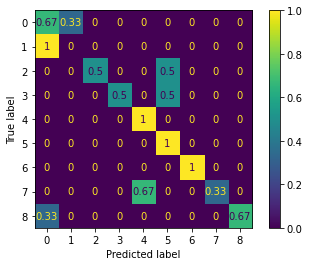

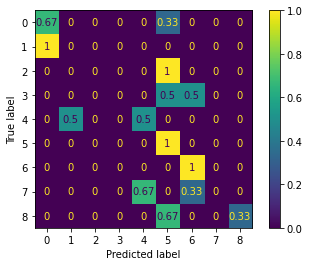

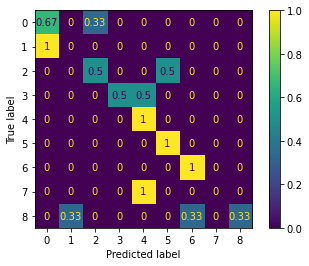

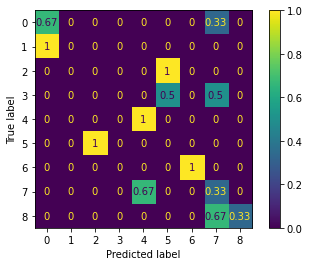

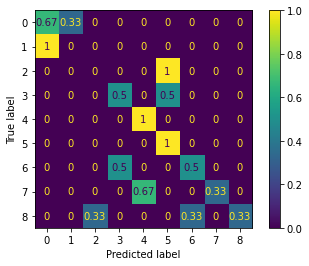

In [20]:
plot_confusion_matrix(lr, X_test, y_test, normalize='true')
plot_confusion_matrix(svm, X_test, y_test, normalize='true')
plot_confusion_matrix(knn9, X_test, y_test, normalize='true')
plot_confusion_matrix(tree, X_test, y_test, normalize='true')
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

In [21]:
scores_lr = cross_val_score(lr, X_train, y_train, cv=5)
scores_svm = cross_val_score(svm, X_train, y_train, cv=5)
scores_knn9 = cross_val_score(knn9, X_train, y_train, cv=5)
scores_tree = cross_val_score(tree, X_train, y_train, cv=5)
scores_clf = cross_val_score(clf, X_train, y_train, cv=5)

C:\Users\guilh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\guilh\anaconda3\lib\site-packages\s

In [22]:
print("LR %0.2f accuracy with a standard deviation of %0.2f" % (scores_lr.mean(), scores_lr.std()))
print("SVM %0.2f accuracy with a standard deviation of %0.2f" % (scores_svm.mean(), scores_svm.std()))
print("KNN %0.2f accuracy with a standard deviation of %0.2f using %d neighbors" % (scores_knn9.mean(), scores_knn9.std(), 9))
print("Tree %0.2f accuracy with a standard deviation of %0.2f " % (scores_tree.mean(), scores_tree.std()))
print("Gradient Boosting %0.2f accuracy with a standard deviation of %0.2f " % (scores_clf.mean(), scores_clf.std()))

LR 0.68 accuracy with a standard deviation of 0.15
SVM 0.56 accuracy with a standard deviation of 0.07
KNN 0.51 accuracy with a standard deviation of 0.06 using 9 neighbors
Tree 0.51 accuracy with a standard deviation of 0.13 
Gradient Boosting 0.54 accuracy with a standard deviation of 0.06 


In [23]:
from sklearn.metrics import classification_report

for i, c in enumerate(list(le.classes_)):
    print(i, c)

In [24]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       1.00      0.50      0.67         2
           4       0.50      1.00      0.67         2
           5       0.33      1.00      0.50         1
           6       1.00      1.00      1.00         2
           7       1.00      0.33      0.50         3
           8       1.00      0.67      0.80         3

    accuracy                           0.60        20
   macro avg       0.69      0.63      0.59        20
weighted avg       0.73      0.60      0.59        20



In [25]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.33      0.50      0.40         2
           5       0.14      1.00      0.25         1
           6       0.50      1.00      0.67         2
           7       0.00      0.00      0.00         3
           8       1.00      0.33      0.50         3

    accuracy                           0.35        20
   macro avg       0.28      0.39      0.27        20
weighted avg       0.32      0.35      0.28        20



C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(classification_report(y_test, y_pred_knn9))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         2
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         2
           4       0.33      1.00      0.50         2
           5       0.50      1.00      0.67         1
           6       0.67      1.00      0.80         2
           7       0.00      0.00      0.00         3
           8       1.00      0.33      0.50         3

    accuracy                           0.50        20
   macro avg       0.50      0.56      0.47        20
weighted avg       0.50      0.50      0.44        20



C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.50      1.00      0.67         2
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         2
           7       0.20      0.33      0.25         3
           8       1.00      0.33      0.50         3

    accuracy                           0.40        20
   macro avg       0.36      0.37      0.33        20
weighted avg       0.40      0.40      0.36        20



C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guilh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
print(classification_report(y_test, y_pred_grad))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.50      0.50      0.50         2
           4       0.50      1.00      0.67         2
           5       0.25      1.00      0.40         1
           6       0.50      0.50      0.50         2
           7       1.00      0.33      0.50         3
           8       1.00      0.33      0.50         3

    accuracy                           0.45        20
   macro avg       0.47      0.48      0.40        20
weighted avg       0.54      0.45      0.42        20

